# Testing batdetect2 pipeline features:

## **Working on features relevant to the use of this pipeline on recovered Audiomoth .wav recordings**

## 1) Figuring out our imports:

### a) Below are the imports pertaining to accessing data and metadata

In [1]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

### b) Below are the imports pertaining to data manipulation

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

### c) Below are the imports pertaining to data visualization

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt

### d) Below are the imports pertaining to the use of the MSDS pipeline

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config

In [38]:
dets = pd.read_csv(f'../output_dir/recover-20230809/Telephone Field/bd2__recover-20230809_UBNA_010.csv')
dets['ref_time'] = pd.to_datetime(dets['input_file'], format="%Y%m%d_%H%M%S", exact=False)
dets_per_file = dets.groupby(['ref_time'])['ref_time'].count()

In [39]:
dets_per_file

ref_time
2023-08-02 04:00:00     7
2023-08-02 04:30:00    31
2023-08-02 05:00:00    22
2023-08-02 05:30:00    60
2023-08-02 06:00:00     3
                       ..
2023-08-09 08:30:00     1
2023-08-09 09:00:00    23
2023-08-09 10:00:00     8
2023-08-09 10:30:00     1
2023-08-09 12:00:00    74
Name: ref_time, Length: 106, dtype: int64

In [46]:
num_dets = pd.read_csv(f'../output_dir/recover-20230809/Telephone Field/activity__recover-20230809_UBNA_010.csv', index_col=0)
num_dets.set_index('date_and_time_UTC', inplace=True)
num_dets

,num_of_detections
date_and_time_UTC,
2023-08-02 03:00:00+00:00,1
2023-08-02 03:30:00+00:00,1
2023-08-02 04:00:00+00:00,7
2023-08-02 04:30:00+00:00,31
2023-08-02 05:00:00+00:00,22
...,...
2023-08-09 11:00:00+00:00,1
2023-08-09 11:30:00+00:00,1
2023-08-09 12:00:00+00:00,74


In [47]:
activity_datetimes = pd.to_datetime(num_dets.index.values)
raw_dates = activity_datetimes.strftime("%m/%d/%y")
raw_times = activity_datetimes.strftime("%H:%M")

col_name = f"num_of_detections"
data = list(zip(raw_dates, raw_times, num_dets[col_name]))
activity = pd.DataFrame(data, columns=["Date (UTC)", "Time (UTC)", col_name])
activity_df = activity.pivot(index="Time (UTC)", columns="Date (UTC)", values=col_name)

In [48]:
activity_df

Date (UTC),08/02/23,08/03/23,08/04/23,08/05/23,08/06/23,08/07/23,08/08/23,08/09/23
Time (UTC),,,,,,,,
03:00,1,1,1,1,1,1,1,1
03:30,1,1,1,1,7,1,1,1
04:00,7,120,29,24,29,23,422,269
04:30,31,185,29,4,43,148,9,1
05:00,22,25,13,5,2,2,1,23
05:30,60,1,1,1,1,2,1,10
06:00,3,1,72,1,1,19,8,12
06:30,62,67,1,10,2,2,10,1
07:00,95,78,1,1,35,1,9,136


In [5]:
ubna_01_df = pd.read_csv('../output_dir/ubna_data_01_collected_audio_records.csv', dtype=str, index_col=0)
ubna_02_df = pd.read_csv('../output_dir/ubna_data_02_collected_audio_records.csv', dtype=str, index_col=0)

In [6]:
cfg = dict()
cfg["input_dir"] = f'{Path.home()}/Documents/Research/Symposium/Recordings'
cfg["output_dir"] = Path("../output_dir")
cfg["hard_drive"] = 'ubna_data_01'

In [7]:
hard_drive_df = pd.read_csv(f'../output_dir/{cfg["hard_drive"]}_collected_audio_records.csv', dtype=str, index_col=0)
hard_drive_df["Datetime UTC"] = pd.DatetimeIndex(hard_drive_df["Datetime UTC"])
hard_drive_df.set_index("Datetime UTC", inplace=True)

site_name = 'Foliage'
data_params = dict()
data_params['site'] = site_name

site_name_cond = hard_drive_df["Site name"] == site_name

file_year_cond = hard_drive_df.index.year == 2022
minute_cond = np.logical_or((hard_drive_df.index).minute == 30, (hard_drive_df.index).minute == 0)
datetime_cond = np.logical_and((hard_drive_df.index).second == 0, minute_cond)
file_error_cond = np.logical_and((hard_drive_df["File duration"]!='File has no comment due to error!'), (hard_drive_df["File duration"]!='File has no Audiomoth-related comment'))
all_errors_cond = np.logical_and((hard_drive_df["File duration"]!='Is empty!'), file_error_cond)

filtered_location_df = hard_drive_df.loc[site_name_cond&datetime_cond&file_year_cond&all_errors_cond].sort_index()
filtered_location_nightly_df = filtered_location_df.between_time('03:00', '13:30', inclusive="left")

data_params['output_dir'] = cfg["output_dir"] / data_params["site"]
print(f"Will save csv file to {data_params['output_dir']}")

Will save csv file to ../output_dir/Foliage


In [8]:
data_params['ref_audio_files'] = filtered_location_nightly_df["File path"].apply(lambda x : Path(x)).values
file_status_cond = filtered_location_nightly_df["File status"] == "Usable for detection"
file_duration_cond = np.isclose(filtered_location_nightly_df["File duration"].astype('float'), 1795)
good_deploy_session_df = filtered_location_nightly_df.loc[file_status_cond&file_duration_cond]
data_params['good_audio_files'] = good_deploy_session_df["File path"].apply(lambda x : Path(x)).values
data_params['recover_folder'] = good_deploy_session_df["Recover folder"].values
data_params['audiomoth_folder'] = good_deploy_session_df["SD card #"].values

In [10]:
good_deploy_session_df

,Site name,Recover folder,AudioMoth #,SD card #,File path,File metadata,File status,Audiomoth temperature,Audiomoth battery,Sample rate,Audiomoth artist ID,File duration,Deployment notes
Datetime UTC,,,,,,,,,,,,,
2022-06-15 03:00:00,Foliage,recover-20220616_unit2,C,010,/mnt/ubna_data_01/recover-20220616_unit2/20220...,Recorded at 03:00:00 15/06/2022 (UTC) by Audio...,Usable for detection,16.1C,4.4V,250000,AudioMoth 24F319055FDF2F5B,1795,Weather has been partly cloudy with occasional...
2022-06-15 03:30:00,Foliage,recover-20220616_unit2,C,010,/mnt/ubna_data_01/recover-20220616_unit2/20220...,Recorded at 03:30:00 15/06/2022 (UTC) by Audio...,Usable for detection,15.6C,4.3V,250000,AudioMoth 24F319055FDF2F5B,1795,Weather has been partly cloudy with occasional...
2022-06-15 04:00:00,Foliage,recover-20220616_unit2,C,010,/mnt/ubna_data_01/recover-20220616_unit2/20220...,Recorded at 04:00:00 15/06/2022 (UTC) by Audio...,Usable for detection,15.6C,4.3V,250000,AudioMoth 24F319055FDF2F5B,1795,Weather has been partly cloudy with occasional...
2022-06-15 04:30:00,Foliage,recover-20220616_unit2,C,010,/mnt/ubna_data_01/recover-20220616_unit2/20220...,Recorded at 04:30:00 15/06/2022 (UTC) by Audio...,Usable for detection,15.5C,4.3V,250000,AudioMoth 24F319055FDF2F5B,1795,Weather has been partly cloudy with occasional...
2022-06-15 05:00:00,Foliage,recover-20220616_unit2,C,010,/mnt/ubna_data_01/recover-20220616_unit2/20220...,Recorded at 05:00:00 15/06/2022 (UTC) by Audio...,Usable for detection,15.2C,4.3V,250000,AudioMoth 24F319055FDF2F5B,1795,Weather has been partly cloudy with occasional...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-25 11:00:00,Foliage,recover-20220825,D,006,/mnt/ubna_data_01/recover-20220825/UBNA_006/20...,Recorded at 11:00:00 25/08/2022 (UTC) by Audio...,Usable for detection,23.1C,3.8V,192000,AudioMoth 249BC30461CBE637,1795,Using 6 Panasonic AA Ni-MH batteries; Used Aco...
2022-08-25 11:30:00,Foliage,recover-20220825,D,006,/mnt/ubna_data_01/recover-20220825/UBNA_006/20...,Recorded at 11:30:00 25/08/2022 (UTC) by Audio...,Usable for detection,22.3C,3.8V,192000,AudioMoth 249BC30461CBE637,1795,Using 6 Panasonic AA Ni-MH batteries; Used Aco...
2022-08-25 12:00:00,Foliage,recover-20220825,D,006,/mnt/ubna_data_01/recover-20220825/UBNA_006/20...,Recorded at 12:00:00 25/08/2022 (UTC) by Audio...,Usable for detection,22.8C,3.8V,192000,AudioMoth 249BC30461CBE637,1795,Using 6 Panasonic AA Ni-MH batteries; Used Aco...


In [38]:
if list(data_params['good_audio_files']) == list(data_params['ref_audio_files']):
    print("All files from deployment session good!")
else:
    print("Error files exist!")

Error files exist!


In [11]:
with exiftool.ExifToolHelper() as et:
    print(et.get_metadata(glob.glob(f'{cfg["input_dir"]}/**/*.WAV', recursive=True)[0]))

[{'SourceFile': '/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20220822/UBNA_001/20220820_033000.WAV', 'ExifTool:ExifToolVersion': 12.63, 'File:FileName': '20220820_033000.WAV', 'File:Directory': '/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20220822/UBNA_001', 'File:FileSize': 689280488, 'File:FileModifyDate': '2023:05:04 13:13:27-07:00', 'File:FileAccessDate': '2023:05:04 13:13:27-07:00', 'File:FileInodeChangeDate': '2023:05:04 18:16:23-07:00', 'File:FilePermissions': 100644, 'File:FileType': 'WAV', 'File:FileTypeExtension': 'WAV', 'File:MIMEType': 'audio/x-wav', 'RIFF:Encoding': 1, 'RIFF:NumChannels': 1, 'RIFF:SampleRate': 192000, 'RIFF:AvgBytesPerSec': 384000, 'RIFF:BitsPerSample': 16, 'RIFF:Comment': 'Recorded at 03:30:00 20/08/2022 (UTC) by AudioMoth 24F3190361CBE990 at medium gain while battery was 4.0V and temperature was 29.1C.', 'RIFF:Artist': 'AudioMoth 24F3190361CBE990', 'Composite:Duration': 1795.00127083333}]


## 2) Initializing our required variables:

### a) Below we initialize our input/output directories and output pipeline csv name

In [34]:
filepath = Path(f"../recover-20220828/UBNA_010/20220826_030000.WAV")

recover_folder = filepath.parents[1].name
recover_date = recover_folder.split('-')[1]
audiomoth_folder = filepath.parents[0].name
audiomoth_unit = audiomoth_folder.split('_')[-1]

### b) Below we initialize our field records depending on what year our data is from to gather the site name

In [35]:
site_name = file_dealer.get_site_name(recover_date, audiomoth_unit)
site_name

'Central Pond'

In [36]:
save_dir = f'../output_dir/{recover_folder}/{site_name}'
detfile_name = f'bd2__{recover_folder}_{audiomoth_folder}'

[filepath, save_dir, detfile_name]

[PosixPath('../recover-20220828/UBNA_010/20220826_030000.WAV'),
 '../output_dir/recover-20220828/Central Pond',
 'bd2__recover-20220828_UBNA_010']

## 3) Test any main pipeline functions using the initialized variables

### a) Below we test-run our pipeline using the main `run_pipeline()` command in `src/batdt2_pipeline.py`

In [18]:
# batdetect2_pipeline.run_pipeline(dirpath, f"{detfile_name}.csv", save_dir, "../output/tmp", True, False)

### b) Below is the function that will be used in our pipeline to plot the activity plots; Use it to test the overall function

In [19]:
# batdetect2_pipeline.plot_dets_as_activity_grid(dirpath, f"{detfile_name}.csv", save_dir, site_name, show_PST=True, save=False)

## 4) Develop any of the main functions below:

### a) Using `dask.dataframe` to concatenate all generated detections into 1 large `pandas.dataframe`.

In [20]:
new_df = dd.read_csv(f"../output_dir/recover-2023*/Telephone Field/bd2__*.csv").compute()
new_df

,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file,class,class_prob,det_prob,individual,Recover Folder,SD Card,Site name
0,162.4855,162.4921,46953.0,56985.0,0.632,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,164.9085,164.9138,44375.0,52060.0,0.528,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,168.0525,168.0585,46953.0,57225.0,0.598,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,168.9195,168.9253,47812.0,58804.0,0.581,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,169.3145,169.3201,46953.0,57417.0,0.629,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12134,1266.3215,1266.3315,42656.0,60657.0,NaN,Echolocation,/mnt/ubna_data_02/recover-20230815/UBNA_012/20...,Pipistrellus pipistrellus,0.480,0.595,-1.0,recover-20230815,UBNA_012,Telephone Field
12135,1266.4115,1266.4166,41796.0,60064.0,NaN,Echolocation,/mnt/ubna_data_02/recover-20230815/UBNA_012/20...,Pipistrellus pipistrellus,0.520,0.580,-1.0,recover-20230815,UBNA_012,Telephone Field
12136,1266.5005,1266.5071,43515.0,58077.0,NaN,Echolocation,/mnt/ubna_data_02/recover-20230815/UBNA_012/20...,Pipistrellus pipistrellus,0.561,0.643,-1.0,recover-20230815,UBNA_012,Telephone Field
12137,1266.6815,1266.6929,45234.0,54740.0,NaN,Echolocation,/mnt/ubna_data_02/recover-20230815/UBNA_012/20...,Pipistrellus pipistrellus,0.439,0.536,-1.0,recover-20230815,UBNA_012,Telephone Field


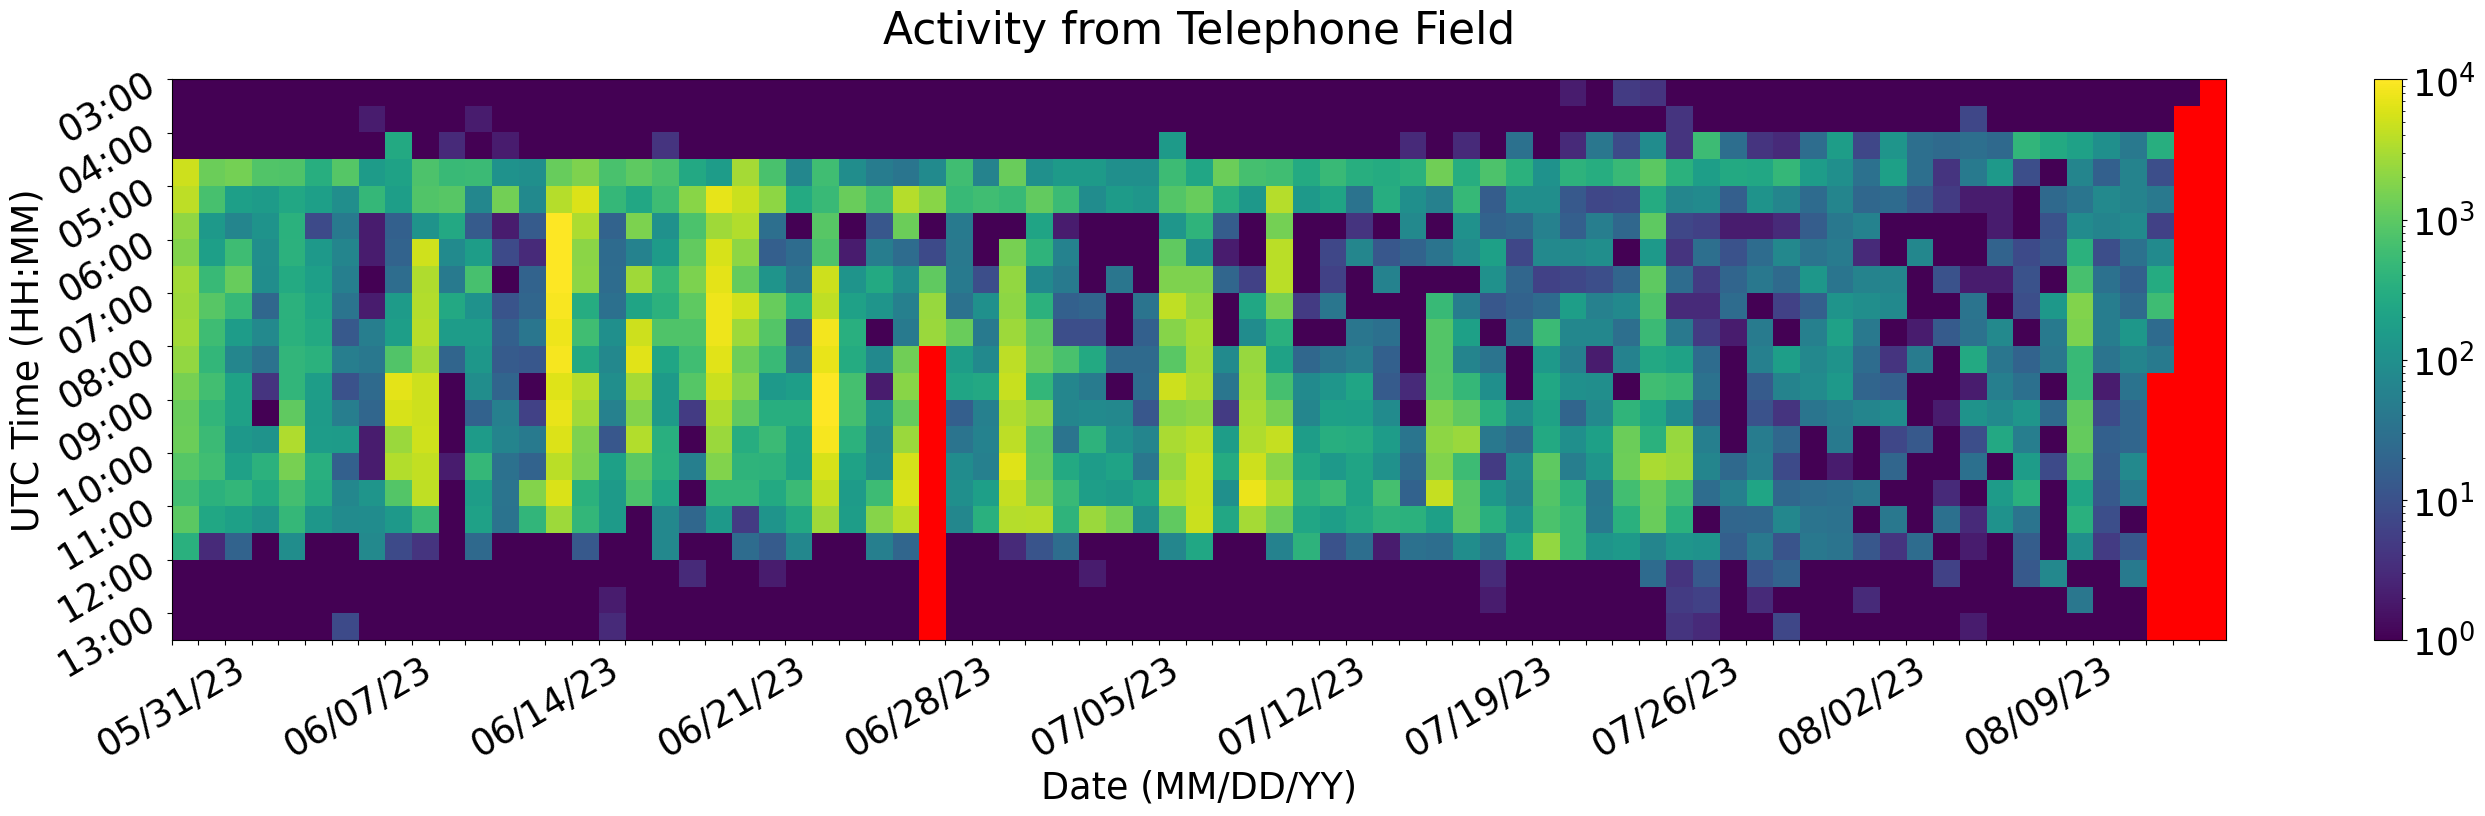

In [21]:
site = "Telephone Field"
cfg["site"] = site
resample_tag = "30T"

activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg['site'], resample_tag)
batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg['site'], resample_tag)

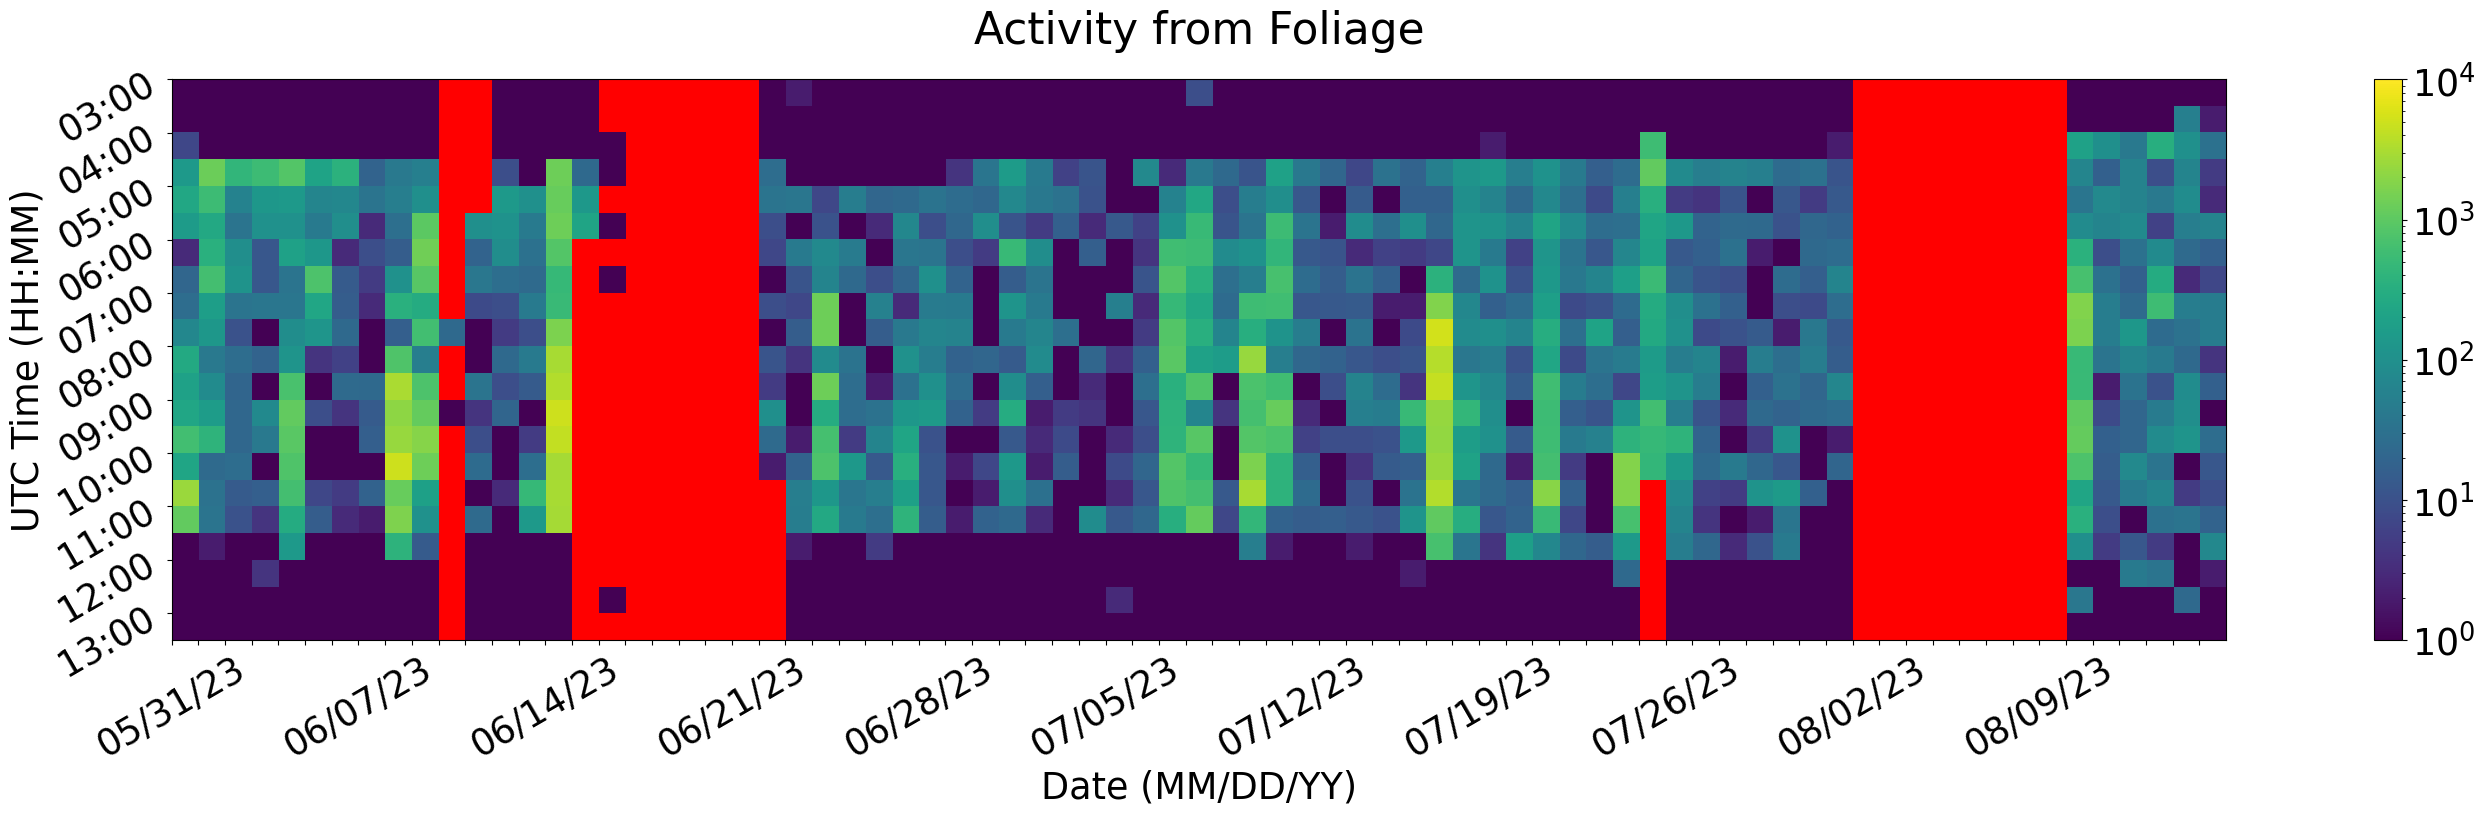

In [22]:
site = "Foliage"
cfg["site"] = site
resample_tag = "30T"

activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg['site'], resample_tag)
batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg['site'], resample_tag)

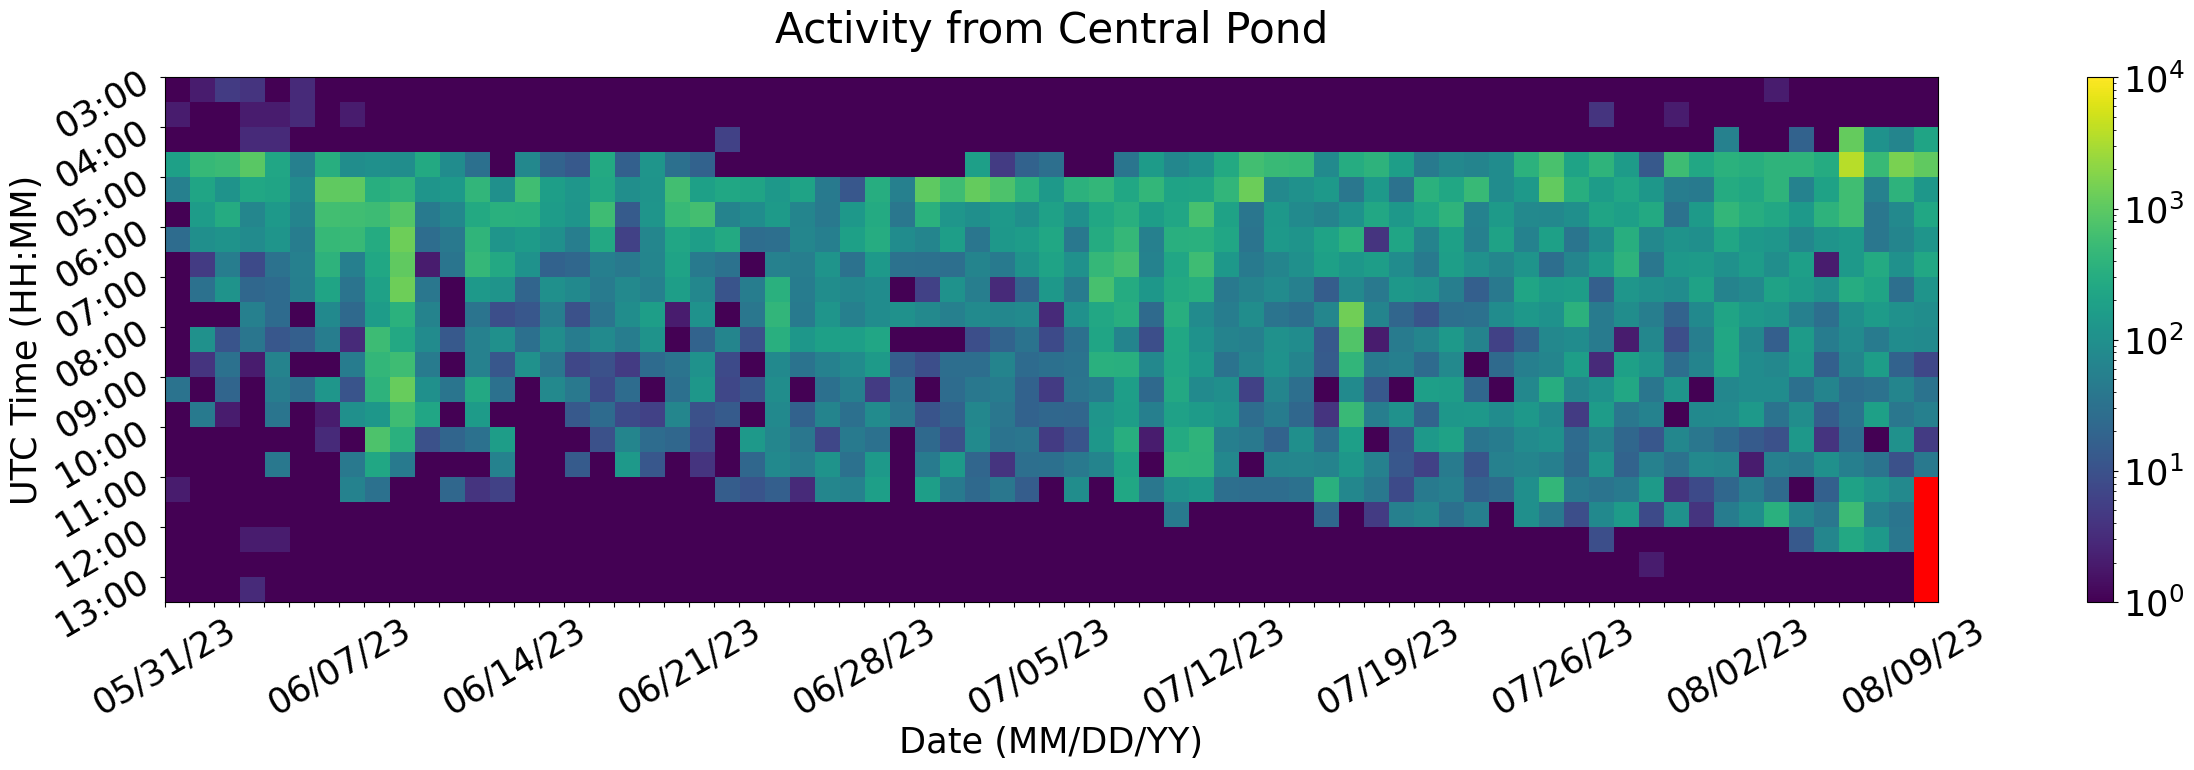

In [23]:
site = "Central Pond"
cfg["site"] = site
resample_tag = "30T"

activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg['site'], resample_tag)
batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg['site'], resample_tag)